In [38]:
import os
import sys
import datetime
import hdbscan
from termcolor import colored, cprint

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys
from os import listdir

import numpy as np
import pandas as pd  # Import Pandas and Numpy to create databases
import tensorflow as tf  # Import tensorflow to do tensor manipulations
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from chasm.glob import glob

from keras.layers import Dense, Input
from keras.models import Model
import numpy as np

from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, concatenate, Input

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import random
from math import floor
from collections import Counter
from sklearn.decomposition import PCA
scaler = StandardScaler()
disease = "ms"
scenario = "abyss"
phenotypes_labels = {
    "bc": "Breast Cancer",
    "cad": "Coronary Artery Disease",
    "ms": "Multiple Sclerosis",
    "t2d": "Type 2 Diabetes",
    "pc": "Prostate Cancer",
    "ibd": "Inflammatory Bowel Disease"
}

scenario_labels = {
    "no_cov": "no covariates",
    "abyss": "Abyss correction",
    "cov": "PCA correction",
    "abyss_cov": "Abyss + PCA as covariates"
}

import seaborn as sns
import matplotlib.pyplot as plt

In [39]:
disease = 'ms'

# Path

In [40]:
path_data = f"/mnt/d/data_1KG/"

In [41]:
path_id_samples = path_data + f"/phenotype/all.panel"
id_samples_total = pd.read_pickle(f"{path_id_samples}")

In [42]:
# Calculate the middle index
middle_index = len(id_samples_total) // 2

# Split the DataFrame into two parts
hodlout = id_samples_total[:middle_index]
id_samples = id_samples_total[middle_index:]

In [43]:
path_input = path_data + f"/genotype/04_LD_blocks/"

In [44]:
list_of_bins = os.listdir(path_input)

In [45]:
snps = []
mafs = []
for bin in list_of_bins:
    path_bin = path_input + f"/{bin}"
    try:
        snp_file = [f for f in os.listdir(path_bin) if not f.startswith("file")][0]
        path_snp = path_bin + f"/{snp_file}"
        snps.append(pd.read_pickle(path_snp))
    except:
        pass

In [46]:
combined_geno = pd.concat(snps, axis=1)

In [47]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(combined_geno)
pca = PCA(n_components=2)  # We specify we want the first 2 PCs
principal_components = pca.fit_transform(scaled_data)

# Step 4: Create a new DataFrame for the first two PCs
pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])


In [48]:
pc_df['pop'] = id_samples['Superpopulation code']

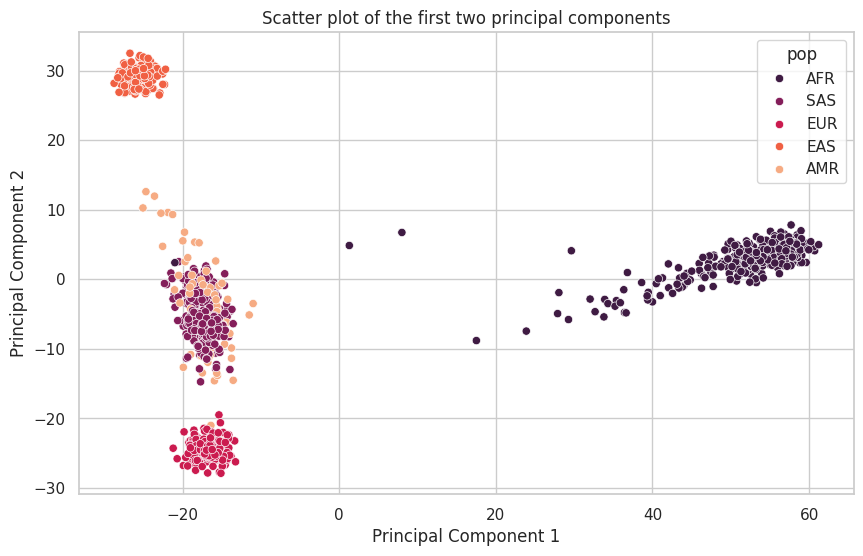

In [49]:
sns.set(style="whitegrid")

# Create a scatter plot
plt.figure(figsize=(10, 6))  # Set the figure size
sns.scatterplot(data=pc_df, x="PC1", y="PC2", hue='pop', palette='rocket')

plt.title('Scatter plot of the first two principal components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()

# Find corresponding sumstats

In [50]:
disease = "ms"
scenario = "abyss"
PCs = 15
logp_min = 7.5
logp_max = 500

In [51]:
path_input = glob.PATH_GENO + f"/02_summary_statistics/{disease}/{scenario}"

In [52]:
list_of_bins = os.listdir(path_input)
list_of_dfs = []
for bin in list_of_bins:
    try:
        temp = pd.read_pickle(path_input+f"/{bin}")
        temp['bin'] = bin.split('_')[1]
        temp = temp[temp['-logp'] > logp_min]
        temp = temp[temp['-logp'] < logp_max]
        list_of_dfs.append(temp)
    except Exception as e:
        print(e)
        print(f"Problem with bin {bin.split('_')[1]}")

# Concatenating the top SNPs from each bin
sumstat = pd.concat(list_of_dfs)

# Sorting by chromosome if needed
sumstat = sumstat.sort_values(by='#CHROM', ascending=True)

In [53]:
sumstat['snp'] = list(combined_geno.columns)[0:len(sumstat['snp'])]

In [54]:
sumstat

,snp,consts,beta_snp,beta_maf,std_err,Z,P,#CHROM,POS,-logp,bin
5892,3:1712837:A:G_G,1.052333,-0.046122,-1.146907,0.012420,-3.713366,0.000211,1,244902468,8.462182,30
32212,3:1712838:A:C_C,-1.523377,0.043336,2.687172,0.012496,3.467918,0.000538,1,206967152,7.527748,17
6617,3:1855547:C:T_T,0.000000,0.043331,0.562651,0.011737,3.691879,0.000230,1,37891045,8.378184,8
9471,3:6193812:A:C_C,1.183388,0.044281,-1.034051,0.012251,3.614554,0.000310,1,113851065,8.079324,22
6120,3:22136577:C:T_T,-0.084379,-0.054065,0.885263,0.012288,-4.399922,0.000012,1,160759519,11.371327,22
...,...,...,...,...,...,...,...,...,...,...,...
33273,2:177706675:A:G_G,2.817694,-0.043249,-2.998909,0.012202,-3.544435,0.000404,22,27956628,7.813097,16
9371,2:189614336:A:G_G,0.000000,0.046255,0.564116,0.012755,3.626444,0.000296,22,19653058,8.124934,8
10736,2:196714169:A:G_A,0.000000,0.051801,0.507578,0.013092,3.956737,0.000079,22,38565347,9.443608,2
21287,2:196736405:A:G_A,0.000000,0.044834,0.516033,0.012695,3.531593,0.000424,22,28371305,7.764845,3


In [55]:
path_LD = glob.PATH_usefull + f"/LD_scores"
list_of_chroms = os.listdir(path_LD)
new_sums = []
for chrom_folder in list_of_chroms:
    chrom = chrom_folder.split("_")[1]
    path_map = path_LD + f"/chrom_{chrom}"
    file = os.listdir(path_map)[0]
    
    path_LDscores = path_map + f"/{file}"
    LDscores = pd.read_pickle(path_LDscores)

    temp_sum = sumstat[sumstat['#CHROM'] == int(chrom)]
    temp_sum = temp_sum.copy()
    
    # Now, you can safely modify it without pandas raising a SettingWithCopyWarning
    temp_sum.loc[:, 'ID'] = temp_sum['snp'].str[:-2]
    n = len(temp_sum['ID'])
    LDscores.loc[:n-1, 'ID'] = list(temp_sum['ID'])
    new_sums.append(temp_sum.merge(LDscores[['ID','LD_score']], on='ID'))

In [56]:
sumstat = pd.concat(new_sums, axis=0, ignore_index=True)

In [57]:
sumstat

,snp,consts,beta_snp,beta_maf,std_err,Z,P,#CHROM,POS,-logp,bin,ID,LD_score
0,8:75724215:C:G_G,0.000000,0.047491,0.551774,0.012701,3.739020,0.000191,19,35500470,8.563076,7,8:75724215:C:G,7.311788
1,8:79508666:A:G_A,0.000000,0.048263,0.555832,0.012683,3.805358,0.000147,19,35502111,8.826737,7,8:79508666:A:G,6.363808
2,8:87938347:A:G_G,0.000000,0.048920,0.555748,0.012665,3.862699,0.000116,19,35501051,9.057911,7,8:87938347:A:G,7.310731
3,8:87939562:A:G_G,-0.468644,0.043465,1.330951,0.012348,3.520006,0.000443,19,11270867,7.721410,17,8:87939562:A:G,1.953881
4,8:95262820:C:G_G,1.018555,-0.044643,-0.616249,0.012438,-3.589204,0.000341,19,5387039,7.982551,11,8:95262820:C:G,7.099132
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1538,2:85619407:A:G_A,-0.300217,-0.042991,1.055699,0.012354,-3.480072,0.000514,21,27465597,7.572710,17,2:85619407:A:G,2.027438
1539,2:109534102:A:G_A,1.928129,-0.048955,-2.080124,0.012334,-3.969256,0.000075,21,39362336,9.495546,21,2:109534102:A:G,10.480175
1540,2:109535891:C:T_C,2.155550,-0.049802,-2.403078,0.012328,-4.039877,0.000056,21,39367443,9.791383,21,2:109535891:C:T,10.571971
1541,2:113470948:A:G_G,0.227904,-0.053156,0.413386,0.012447,-4.270506,0.000021,21,39372634,10.789627,22,2:113470948:A:G,10.306983


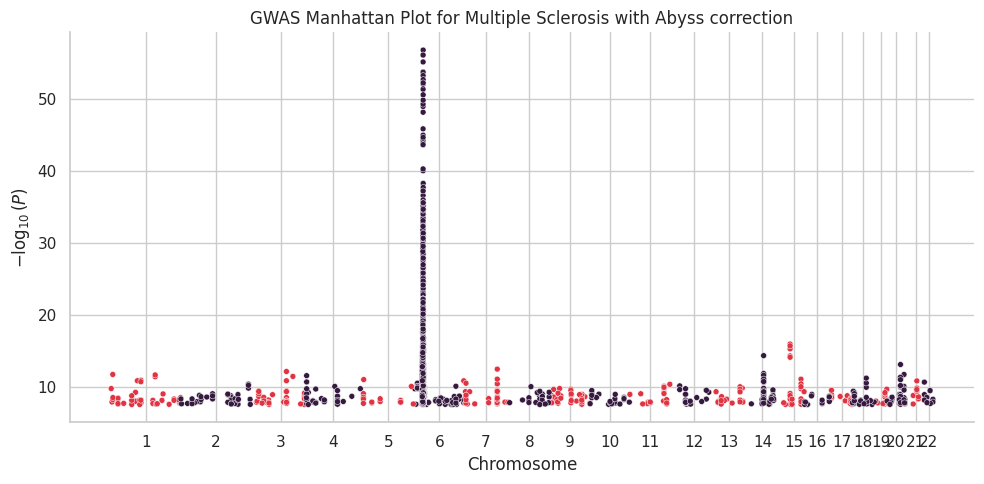

In [58]:
running_pos = 0
cumulative_pos = []
for chrom, group_df in sumstat.groupby('#CHROM'):
    cumulative_pos.append(group_df['POS'] + running_pos)
    running_pos += group_df['POS'].max()

sumstat['cumulative_pos'] = pd.concat(cumulative_pos)
sumstat['SNP number'] = sumstat.index

# Define two contrasting colors from the rocket palette
palette = sns.color_palette("rocket", as_cmap=False)
color1 = palette[3]  # First color of the palette
color2 = palette[0] # Last color of the palette, for maximum contrast

# Function to assign color based on chromosome
def assign_color(chrom_number):
    return color1 if chrom_number % 2 == 0 else color2

# Apply the function to create a color column
sumstat['color'] = sumstat['#CHROM'].apply(assign_color)

chrom_midpoints = []
for chrom, group_df in sumstat.groupby('#CHROM'):
    midpoint = group_df['cumulative_pos'].min() + (group_df['cumulative_pos'].max() - group_df['cumulative_pos'].min()) / 2
    chrom_midpoints.append(midpoint)

# Plotting
g = sns.relplot(
    data=sumstat,
    x='cumulative_pos',
    y='-logp',
    aspect=2,
    hue='color',
    palette=[color1, color2],
    legend=False,
    size=3 
)


# Set x-axis ticks and labels with reversed chromosome order
chrom_labels = np.sort(sumstat['#CHROM'].unique()) # Reversing the order of chromosomes

# Set the title and x-axis, y-axis labels
g.set(title=f"GWAS Manhattan Plot for {phenotypes_labels[disease]} with {scenario_labels[scenario]}")
g.set(xticks=chrom_midpoints, xticklabels=chrom_labels)
g.set_axis_labels("Chromosome", r"$-\log_{10}(P)$")  # Set y-axis label with subscript

# Set the tick labels at a 45-degree angle
for ax in g.axes.flat:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Optional: Improve the layout
plt.tight_layout()
plt.show()

In [59]:
temp = combined_geno.T
temp['snp'] = temp.index
combined_geno = temp.merge(sumstat[['snp','POS','LD_score','beta_snp']], on='snp')
column_names = combined_geno['snp']
combined_geno = combined_geno.T
combined_geno.columns = column_names

In [60]:
# Extract chromosome numbers and group columns
chromosome_to_columns = {}
for col in combined_geno.columns:
    chromosome = col.split(':')[0]
    if chromosome not in chromosome_to_columns:
        chromosome_to_columns[chromosome] = []
    chromosome_to_columns[chromosome].append(col)

# Split into separate DataFrames based on chromosome
chromosome_dfs = {}
for chromosome, cols in chromosome_to_columns.items():
    chromosome_dfs[chromosome] = combined_geno[cols]

In [61]:
# test if ids still correspond
chromosome_dfs['3']
rows_to_drop = ['snp', 'POS', 'LD_score', 'beta_snp']
temp = chromosome_dfs['3'].drop(index=rows_to_drop)

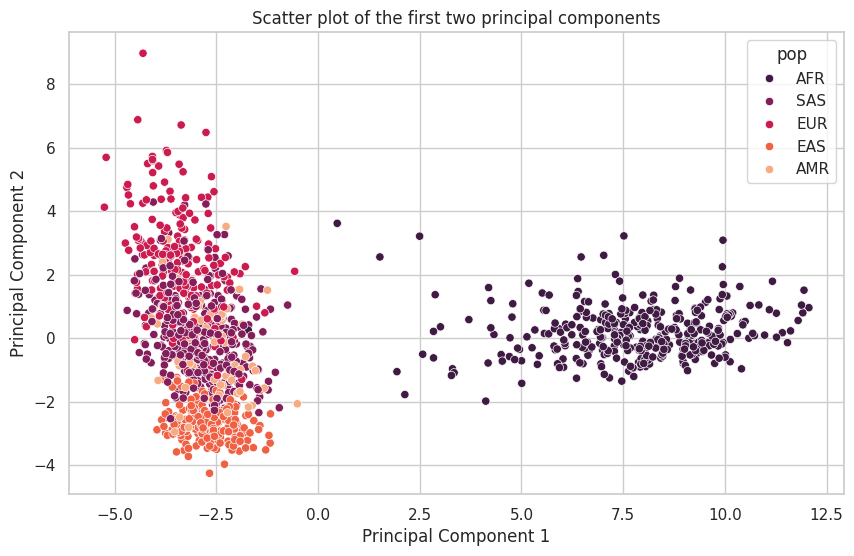

In [62]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(temp)
pca = PCA(n_components=2)  # We specify we want the first 2 PCs
principal_components = pca.fit_transform(scaled_data)

# Step 4: Create a new DataFrame for the first two PCs
pc_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pc_df['pop'] = id_samples['Superpopulation code']
sns.set(style="whitegrid")

# Create a scatter plot
plt.figure(figsize=(10, 6))  # Set the figure size
sns.scatterplot(data=pc_df, x="PC1", y="PC2", hue='pop', palette='rocket')

plt.title('Scatter plot of the first two principal components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()

In [63]:
# Still ok

In [64]:
snp_ids = []
chroms = []
labels = []
LDs = []
POSs = []
betas = []

snps_array = []
scaled_dfs = []
for chrom_key in chromosome_dfs.keys():
    genos_with_cov = chromosome_dfs[chrom_key]
    snp_names = np.array(genos_with_cov.iloc[-4])
    positions = np.array(genos_with_cov.iloc[-3])
    ld_scores = np.array(genos_with_cov.iloc[-2])
    beta_snp = np.array(genos_with_cov.iloc[-1])
    genos = genos_with_cov.iloc[:-4].copy()
    genos_trans = genos.T

    ld_score_df = pd.DataFrame({'snp': snp_names, 'LD_score': ld_scores, 'POS': positions, 'beta':beta_snp})
    # Apply HDBSCAN for clustering
    clusterer = hdbscan.HDBSCAN(min_cluster_size=5)  # you can adjust the min_cluster_size as needed
    scaled_df = scaler.fit_transform(ld_score_df[['LD_score','POS','beta']])
    scaled_dfs.append(scaled_df)
    cluster_labels = clusterer.fit_predict(np.array(scaled_df))

    genos_trans['clusters'] = cluster_labels
    genos_trans['LD'] = ld_scores
    genos_trans['POS'] = positions
    genos_trans['beta'] = beta_snp

    for num in genos_trans.clusters.unique():
        to_save = genos_trans.loc[genos_trans['clusters'] == num]
        to_save_snps = to_save.drop(columns=['clusters','LD','POS','beta']).T
        to_save_LD = to_save[['LD']].T
        to_save_pos = to_save[['POS']].T
        to_save_beta = to_save[['beta']].T

        for snp_id in to_save_snps:
            snp_ids.append(snp_id)
            chroms.append(chrom_key)
            labels.append(f"{chrom_key}_{num}")
            LDs.append(to_save_LD.loc['LD'][snp_id])
            POSs.append(to_save_pos.loc['POS'][snp_id])
            betas.append(to_save_beta.loc['beta'][snp_id])
        snps_array.append(to_save_snps)

In [65]:
data = {
    'snp': snp_ids,
    'chroms': chroms,
    'labels': labels,
    'LD': LDs,
    'POS': POSs,
    'beta':betas
}
df = pd.DataFrame(data)

In [66]:
dfs = []
# Iterate through the arrays and add a 'chromosome' column
for i, array in enumerate(scaled_dfs):
    df1 = pd.DataFrame(array, columns=['LD', 'POS', 'beta'])
    df1['chromosome'] = i + 1  # Assuming chromosomes start from 1
    dfs.append(df1)

# Concatenate all dataframes into one
result_df = pd.concat(dfs, ignore_index=True)

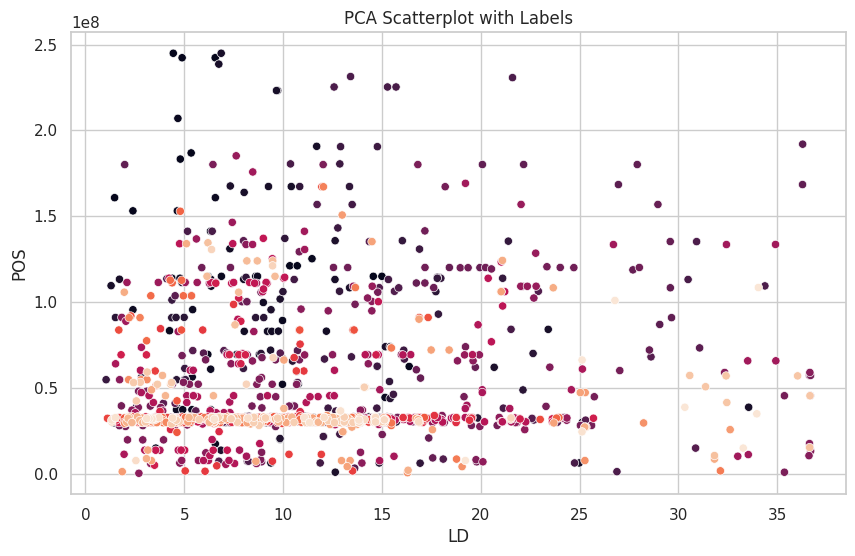

In [67]:
# Create a seaborn scatterplot

plt.figure(figsize=(10, 6))

scatter = sns.scatterplot(x='LD', y='POS', hue='labels', palette='rocket', data=df, legend= False)



# Enhancing the plot

scatter.set_title('PCA Scatterplot with Labels')


plt.show()

In [68]:
temp_sumstat = pd.merge(sumstat, df, on='snp', how='inner')

In [69]:
temp_sumstat['#CHROM'].unique()

array([19,  6, 20, 22, 17,  9, 10,  7, 18, 15, 12, 11, 13,  3,  1,  2,  4,
        5,  8, 16, 14, 21])

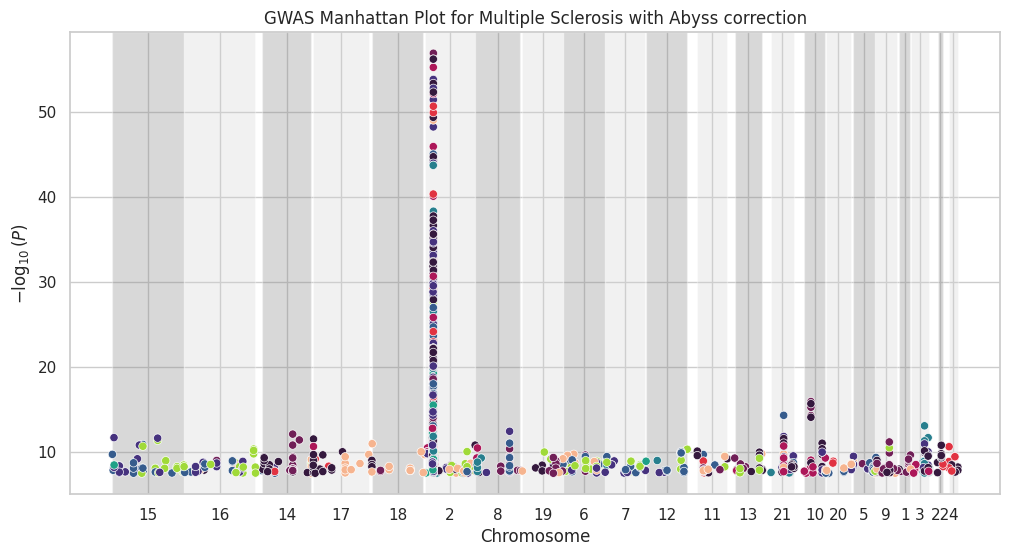

In [70]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define two palettes

even_palette = sns.color_palette("rocket")  # Lighter palette for even chromosomes
odd_palette = sns.color_palette("viridis")     # Darker palette for odd chromosomes

# Define background colors for segments
bg_color_even = "lightgrey"  # Background color for even segments
bg_color_odd = "grey"        # Background color for odd segments

# Create a figure for the Manhattan plot
plt.figure(figsize=(12, 6))

# Get start, end positions and midpoints for each chromosome
chromosomes = temp_sumstat['#CHROM'].unique()
chrom_midpoints = []
start_end_positions = []
for chrom in chromosomes:
    start = temp_sumstat[temp_sumstat['#CHROM'] == chrom]['cumulative_pos'].min()
    end = temp_sumstat[temp_sumstat['#CHROM'] == chrom]['cumulative_pos'].max()
    midpoints = (start + end) / 2
    chrom_midpoints.append(midpoints)
    start_end_positions.append((start, end))

# Add a background color for each chromosome segment
for i, (start, end) in enumerate(start_end_positions):
    chrom = chromosomes[i]
    plt.axvspan(start, end, facecolor=bg_color_even if chrom % 2 == 0 else bg_color_odd, alpha=0.3)

# Plot the data
sns.scatterplot(
    data=temp_sumstat,
    x='cumulative_pos',
    y='-logp',
    hue='labels',
    palette={label: (even_palette if int(label.split('_')[0]) % 2 == 0 else odd_palette)[int(label.split('_')[1]) % len(even_palette)] for label in temp_sumstat['labels'].unique()},
    legend=False
)

# Set title and axis labels
plt.title(f"GWAS Manhattan Plot for {phenotypes_labels[disease]} with {scenario_labels[scenario]}")
plt.xlabel("Chromosome")
plt.ylabel(r"$-\log_{10}(P)$")

# Set x-axis ticks and labels with reversed chromosome order
chrom_labels = np.sort(chromosomes)  # Reversing the order of chromosomes
plt.xticks(chrom_midpoints, chrom_labels)

# Set the tick labels at a 45-degree angle
plt.xticks(rotation=0)

# Show the plot
plt.show()


In [71]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
l2_lambda = 0.01

In [72]:
id_samples['phenotype'] = np.where(id_samples['Superpopulation code'] == 'EUR', 1, 0)
id_samples['FID'] = id_samples['Sample name']

/tmp/ipykernel_97368/2045770020.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  id_samples['phenotype'] = np.where(id_samples['Superpopulation code'] == 'EUR', 1, 0)
/tmp/ipykernel_97368/2045770020.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  id_samples['FID'] = id_samples['Sample name']


In [78]:
path_pheno = glob.PATH_PHENO
pheno = id_samples[['FID','phenotype']]

class CustomDenseLayer(Dense):
    def __init__(self, units, betas, l2_lambda=0.01, **kwargs):
        super().__init__(units, kernel_regularizer=l2(l2_lambda), **kwargs)
        self.initial_weights = betas

    def build(self, input_shape):
        super().build(input_shape)
        self.set_weights([self.initial_weights.reshape(-1, 1)])

# Your snps_array and other data preparations remain the same

# Define a list to hold your sub-models
sub_models = []
genos = []
X_trains = []
X_tests = []

#pheno = pheno.sample(frac=1)
len_test = round(pheno.shape[0] / 10) * 3
len_train = pheno.shape[0] - len_test
y_train = pheno[['phenotype']].head(len_train)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test = pheno[['phenotype']].tail(len_test)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

for snps_cluster in snps_array:
    #betas = np.array(snps_cluster.iloc[-1])
    geno = snps_cluster
    geno['FID'] = id_samples_total['Sample name']
    geno = geno.merge(id_samples[['FID']], on='FID')
    geno.drop('FID',axis=1)
    temp = geno.T
    temp['snp'] = temp.index
    temp = temp.reset_index(drop=True)
    betas = np.array(temp[['snp']].merge(sumstat[['snp','beta_snp']], on='snp')['beta_snp'])
    geno['FID'] = list(id_samples['FID'])
    # Merge genotype data with phenotype data
    geno = pd.merge(geno, pheno[['FID']], on='FID')
    geno = geno.drop('FID', axis=1)
    
    X_train = geno.head(len_train)
    X_train = scaler.fit_transform(X_train)
    X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
    X_trains.append(X_train)
    X_test = geno.tail(len_test)
    X_test = scaler.fit_transform(X_test)
    X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
    X_tests.append(X_test)
    #genos.append(geno)
    # Create the Keras sub-model
    model_input = Input(shape=(geno.shape[1],))
    genos.append(geno)
    custom_layer = CustomDenseLayer(1, betas, use_bias=False)(model_input)
    sub_model = Model(inputs=model_input, outputs=custom_layer)
    
    sub_models.append(sub_model)

# Concatenate the outputs of the sub-models
concatenated_outputs = concatenate([model.output for model in sub_models])

# Add the final trainable dense layer
final_layer = Dense(1, activation='linear', kernel_regularizer=l2(l2_lambda))(concatenated_outputs)

# Create the final model
final_model = Model(inputs=[model.input for model in sub_models], outputs=final_layer)

# Compile the final model
final_model.compile(optimizer='Adam', loss='mean_squared_error')

# Train the model
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = final_model.fit(X_trains, y_train, epochs=30, batch_size=32, validation_data=(X_tests, y_test), callbacks=[early_stopping_callback])

train_loss = history.history['loss']
val_loss = history.history['val_loss']

Epoch 1/30
28/28 [==============================] - 5s 39ms/step - loss: 0.3788 - val_loss: 0.3612
Epoch 2/30
28/28 [==============================] - 0s 10ms/step - loss: 0.1824 - val_loss: 0.3039
Epoch 3/30
28/28 [==============================] - 0s 9ms/step - loss: 0.1411 - val_loss: 0.2679
Epoch 4/30
28/28 [==============================] - 0s 9ms/step - loss: 0.1149 - val_loss: 0.2454
Epoch 5/30
28/28 [==============================] - 0s 8ms/step - loss: 0.0968 - val_loss: 0.2238
Epoch 6/30
28/28 [==============================] - 0s 7ms/step - loss: 0.0842 - val_loss: 0.2083
Epoch 7/30
28/28 [==============================] - 0s 8ms/step - loss: 0.0732 - val_loss: 0.1934
Epoch 8/30
28/28 [==============================] - 0s 8ms/step - loss: 0.0651 - val_loss: 0.1874
Epoch 9/30
28/28 [==============================] - 0s 7ms/step - loss: 0.0587 - val_loss: 0.1768
Epoch 10/30
28/28 [==============================] - 0s 8ms/step - loss: 0.0533 - val_loss: 0.1700
Epoch 11/30
28/28

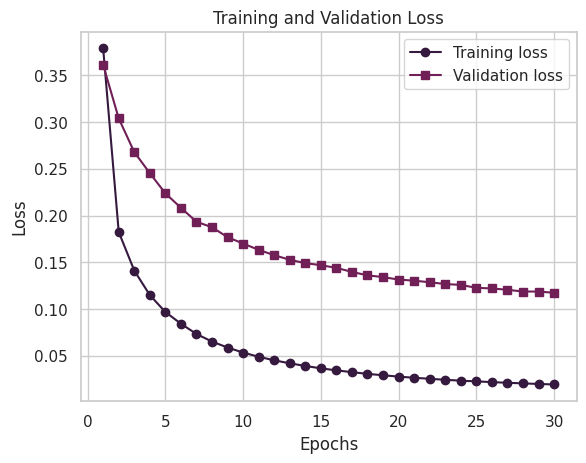

In [79]:
# Setting the style to 'rocket' from seaborn
sns.set(style="whitegrid", palette="rocket")

epochs = range(1, len(train_loss) + 1)

plt.figure()
plt.plot(epochs, train_loss, 'o-', label='Training loss')
plt.plot(epochs, val_loss, 's-', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [83]:
id_samples

,Sample name,Sex,Population code,Population name,Superpopulation code,Superpopulation name,phenotype,FID
1252,HG03268,male,ESN,Esan,AFR,African Ancestry,0,HG03268
1253,HG03270,female,ESN,Esan,AFR,African Ancestry,0,HG03270
1254,HG03271,male,ESN,Esan,AFR,African Ancestry,0,HG03271
1255,HG03279,female,ESN,Esan,AFR,African Ancestry,0,HG03279
1256,HG03280,male,ESN,Esan,AFR,African Ancestry,0,HG03280
...,...,...,...,...,...,...,...,...
2499,NA21137,female,GIH,Gujarati,SAS,South Asian Ancestry,0,NA21137
2500,NA21141,female,GIH,Gujarati,SAS,South Asian Ancestry,0,NA21141
2501,NA21142,female,GIH,Gujarati,SAS,South Asian Ancestry,0,NA21142
2502,NA21143,female,GIH,Gujarati,SAS,South Asian Ancestry,0,NA21143


In [81]:
hodlout

,Sample name,Sex,Population code,Population name,Superpopulation code,Superpopulation name
0,HG00096,male,GBR,British,EUR,European Ancestry
1,HG00097,female,GBR,British,EUR,European Ancestry
2,HG00099,female,GBR,British,EUR,European Ancestry
3,HG00100,female,GBR,British,EUR,European Ancestry
4,HG00101,male,GBR,British,EUR,European Ancestry
...,...,...,...,...,...,...
1247,HG03247,female,GWD,Gambian Mandinka,AFR,African Ancestry
1248,HG03258,male,GWD,Gambian Mandinka,AFR,African Ancestry
1249,HG03259,female,GWD,Gambian Mandinka,AFR,African Ancestry
1250,HG03265,male,ESN,Esan,AFR,African Ancestry


In [80]:
pheno = hodlout[['FID','phenotype']]

KeyError: "None of [Index(['FID', 'phenotype'], dtype='object')] are in the [columns]"

In [ ]:
X_holdouts = []
for snps_cluster in snps_array:
    geno = snps_cluster
    geno['FID'] = list(id_samples['FID'])
    # Merge genotype data with phenotype data
    geno = pd.merge(geno, pheno[['FID']], on='FID')
    geno = geno.drop('FID', axis=1)
    X_holdout = scaler.fit_transform(geno)
    X_holdout = tf.convert_to_tensor(X_holdout, dtype=tf.float32)
    X_holdouts.append(X_holdout)